### 忽略无关警告

In [1]:
# Ignore irrelevant warnings 
import warnings
warnings.filterwarnings('ignore')

### 导入必要的库

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
import pandas as pd

In [3]:
# 模型训练
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### 导入检查数据异常值的模型，这些算法都被集成在PYOD工具包下，本次作业主要使用该工具包进行异常点和离群点检测

In [4]:
# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.cof import COF
from pyod.models.pca import PCA


## 一、处理 wine_banchmark 数据集

### 1.1读取所有csv文件并合并成一个dataframe,把包含noise和不包含noise的分为两个数据集

In [5]:
# 读取所有csv文件
from os import walk
df=[]
dfnose = []
for f,_ ,i in walk("F:/Data Mining/homework4/wine_benchmarks/wine/benchmarks"):
    for j in i:
        temp = pd.read_csv(f+'/'+j)
        if temp.shape[1] ==17:
            df.append(temp)
        elif temp.shape[1]==50:
            dfnose.append(temp)

In [6]:
# 合并成一个dataframe
dfAll = pd.concat(df)
dfNAll = pd.concat(dfnose)
print(dfAll.columns)
print(dfNAll.columns)

Index(['point.id', 'motherset', 'origin', 'original.label', 'diff.score',
       'ground.truth', 'fixed.acidity', 'volatile.acidity', 'citric.acid',
       'residual.sugar', 'chlorides', 'free.sulfur.dioxide',
       'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype='object')
Index(['point.id', 'motherset', 'origin', 'original.label', 'diff.score',
       'ground.truth', 'fixed.acidity', 'volatile.acidity', 'citric.acid',
       'residual.sugar', 'chlorides', 'free.sulfur.dioxide',
       'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'noise..1', 'noise..2', 'noise..3', 'noise..4', 'noise..5', 'noise..6',
       'noise..7', 'noise..8', 'noise..9', 'noise..10', 'noise..11',
       'noise..12', 'noise..13', 'noise..14', 'noise..15', 'noise..16',
       'noise..17', 'noise..18', 'noise..19', 'noise..20', 'noise..21',
       'noise..22', 'noise..23', 'noise..24', 'noise..25', 'noise..26',
       'noise..27', 'noise..28', 'noise..29', 'no

### 1.2 由于motherset、origin只有一个值，所以舍去该属性

In [7]:
print(dfAll['origin'].value_counts())
print(dfAll['motherset'].value_counts())

regression    1049492
Name: origin, dtype: int64
wine    1049492
Name: motherset, dtype: int64


In [8]:
# 属性列表
column_names = ['point.id', 'original.label', 'diff.score',
       'ground.truth', 'fixed.acidity', 'volatile.acidity', 'citric.acid',
       'residual.sugar', 'chlorides', 'free.sulfur.dioxide',
       'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol']
noise_column_names = ['point.id', 'original.label', 'diff.score',
       'ground.truth', 'fixed.acidity', 'volatile.acidity', 'citric.acid',
       'residual.sugar', 'chlorides', 'free.sulfur.dioxide',
       'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'noise..1', 'noise..2', 'noise..3', 'noise..4', 'noise..5', 'noise..6',
       'noise..7', 'noise..8', 'noise..9', 'noise..10', 'noise..11',
       'noise..12', 'noise..13', 'noise..14', 'noise..15', 'noise..16',
       'noise..17', 'noise..18', 'noise..19', 'noise..20', 'noise..21',
       'noise..22', 'noise..23', 'noise..24', 'noise..25', 'noise..26',
       'noise..27', 'noise..28', 'noise..29', 'noise..30', 'noise..31',
       'noise..32', 'noise..33']

In [9]:
wineDF = dfAll[column_names]
print('删除前元组数：'+str(len(wineDF)))
# 删除所有属性值都相同的元组
wineDF = wineDF.drop_duplicates()
print('删除后元组数：'+str(len(wineDF)))

wineNDF = dfNAll[noise_column_names]
print('noise数据集删除前元组数：'+str(len(wineNDF)))
# 删除所有属性值都相同的元组
wineNDF = wineNDF.drop_duplicates()
print('noise数据集删除后元组数：'+str(len(wineNDF)))

删除前元组数：1049492
删除后元组数：6497
noise数据集删除前元组数：1044743
noise数据集删除后元组数：1044743


In [10]:
#重新建议序号索引
wineDF.reset_index(inplace=True,drop=True)
# noise数据集过多，训练时间会超长，所以进行随机抽样
wineNDF = wineNDF.sample(10000)

### 1.3 创建模型字典

#### 1.3.1这里使用10种不同的算法来进行训练

In [11]:
# 使用一下模型进行离群点分析
random_state = np.random.RandomState(52)
outliers_fraction = 0.1

classifiers = {
        'Fast Angle-based Outlier Detector (F_ABOD)': ABOD(contamination=outliers_fraction,method='fast'),
        #'Original Angle-based Outlier Detector (O_ABOD)': ABOD(contamination=outliers_fraction,method='default'),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(n_neighbors=250, method='largest',contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction),
        'Local Outlier Factor (LOF)':LOF(contamination=outliers_fraction,n_neighbors=200),
        'Connectivity-Based Outlier Factor (COF)':LOF(contamination=outliers_fraction,n_neighbors=200),
        'Principal Component Analysis Outlier Detector (PCA)':PCA(contamination=outliers_fraction,weighted=True,n_components='mle',svd_solver ='full')
}

### 1.4 首先处理不包含noise的数据集

In [12]:
# 构造数据集
trainDF = wineDF
trainDF['ground.truth']=trainDF['ground.truth'].map({'nominal': 0,'anomaly':1})

### 1.4.1 开始训练，并在测试数据集上进行预测。最后计算ROC以及precision, 并绘制ROC曲线图，输出离群点的个数

使用算法Fast Angle-based Outlier Detector (F_ABOD) 进行建模：

在训练数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.519, precision @ rank n:0.3829

在测试数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.5009, precision @ rank n:0.3832


<Figure size 432x288 with 0 Axes>

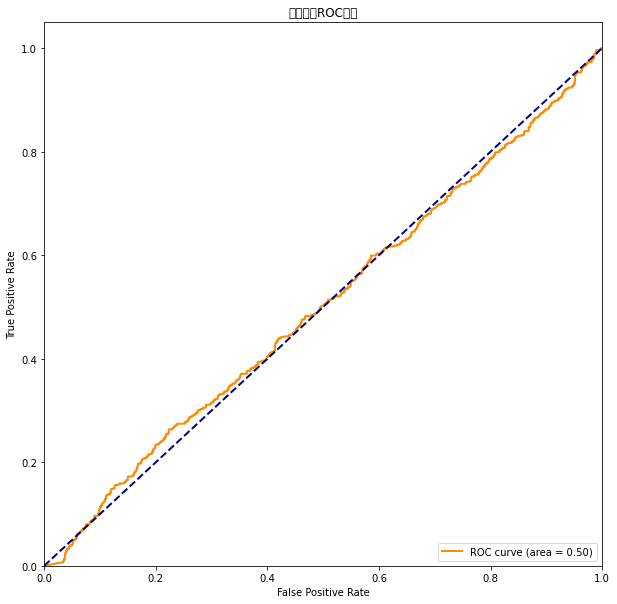

OUTLIERS :  0 INLIERS :  1950 Fast Angle-based Outlier Detector (F_ABOD)
使用算法Cluster-based Local Outlier Factor (CBLOF) 进行建模：

在训练数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.5633, precision @ rank n:0.4308

在测试数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.5717, precision @ rank n:0.4429


<Figure size 432x288 with 0 Axes>

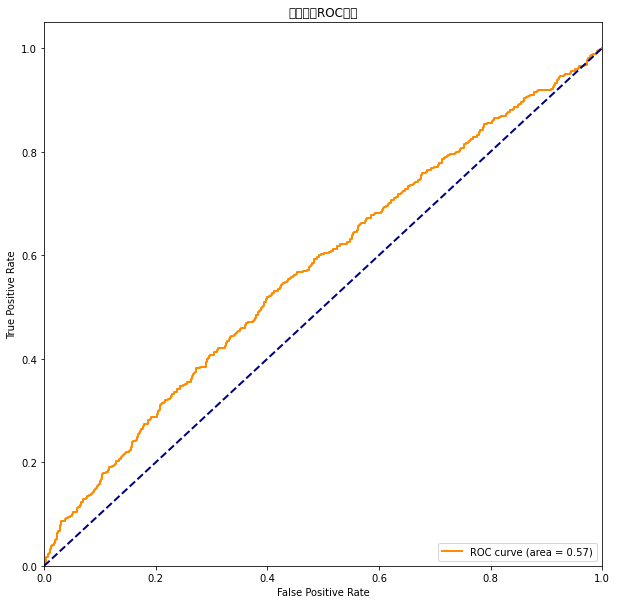

OUTLIERS :  196 INLIERS :  1754 Cluster-based Local Outlier Factor (CBLOF)
使用算法Feature Bagging 进行建模：

在训练数据集中:
Feature Bagging ROC:0.559, precision @ rank n:0.4144

在测试数据集中:
Feature Bagging ROC:0.5568, precision @ rank n:0.4185


<Figure size 432x288 with 0 Axes>

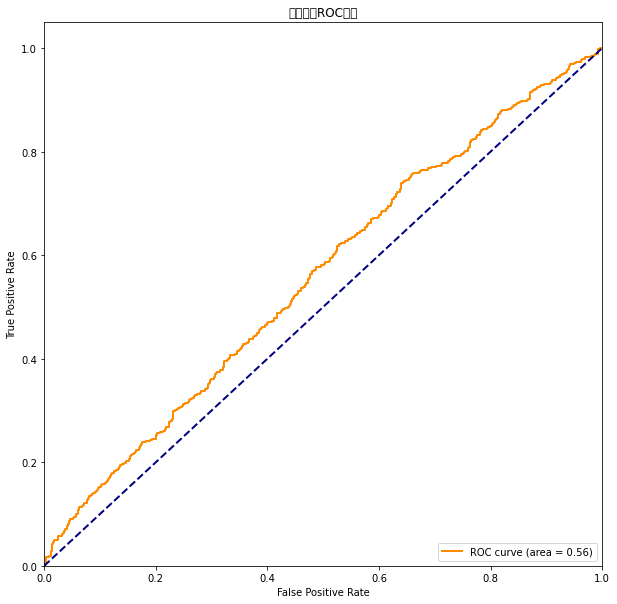

OUTLIERS :  217 INLIERS :  1733 Feature Bagging
使用算法Histogram-base Outlier Detection (HBOS) 进行建模：

在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5535, precision @ rank n:0.4203

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5636, precision @ rank n:0.4416


<Figure size 432x288 with 0 Axes>

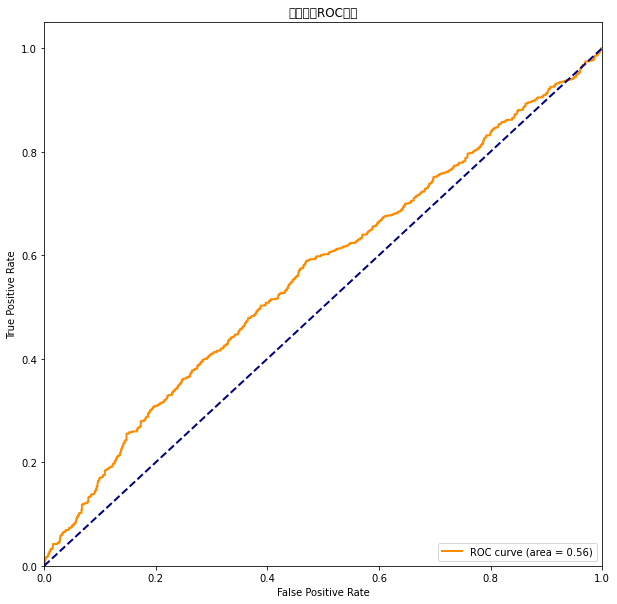

OUTLIERS :  178 INLIERS :  1772 Histogram-base Outlier Detection (HBOS)
使用算法Isolation Forest 进行建模：

在训练数据集中:
Isolation Forest ROC:0.5088, precision @ rank n:0.3807

在测试数据集中:
Isolation Forest ROC:0.5271, precision @ rank n:0.3954


<Figure size 432x288 with 0 Axes>

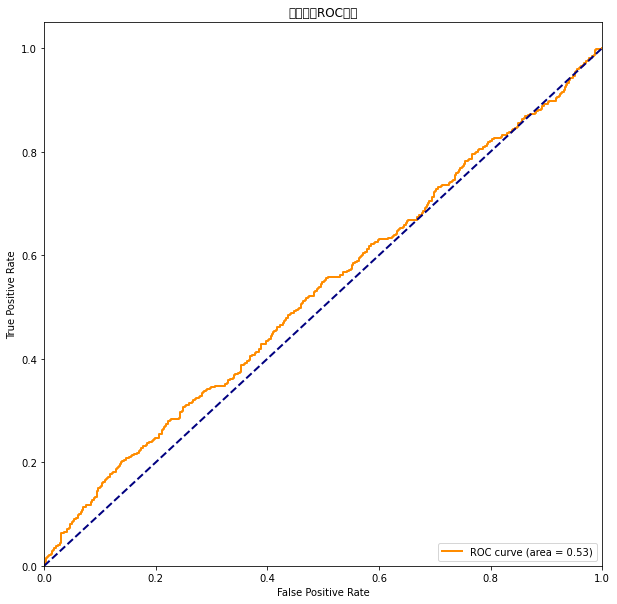

OUTLIERS :  194 INLIERS :  1756 Isolation Forest
使用算法K Nearest Neighbors (KNN) 进行建模：

在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5842, precision @ rank n:0.4308

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6002, precision @ rank n:0.466


<Figure size 432x288 with 0 Axes>

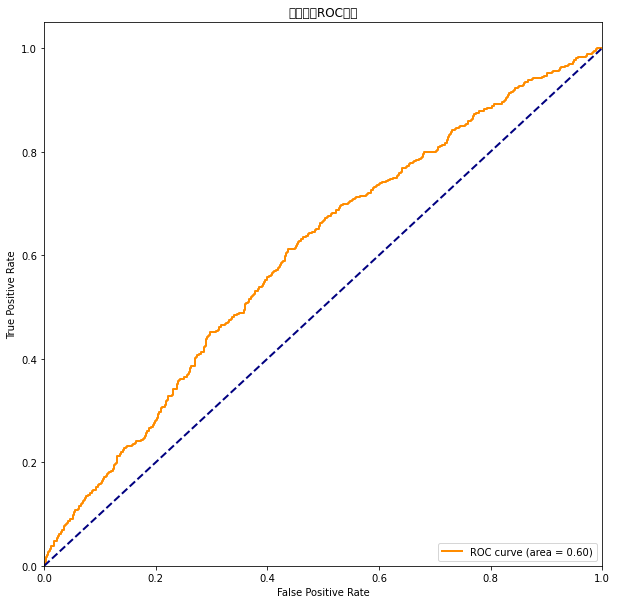

OUTLIERS :  189 INLIERS :  1761 K Nearest Neighbors (KNN)
使用算法Average KNN 进行建模：

在训练数据集中:
Average KNN ROC:0.537, precision @ rank n:0.3999

在测试数据集中:
Average KNN ROC:0.5505, precision @ rank n:0.4266


<Figure size 432x288 with 0 Axes>

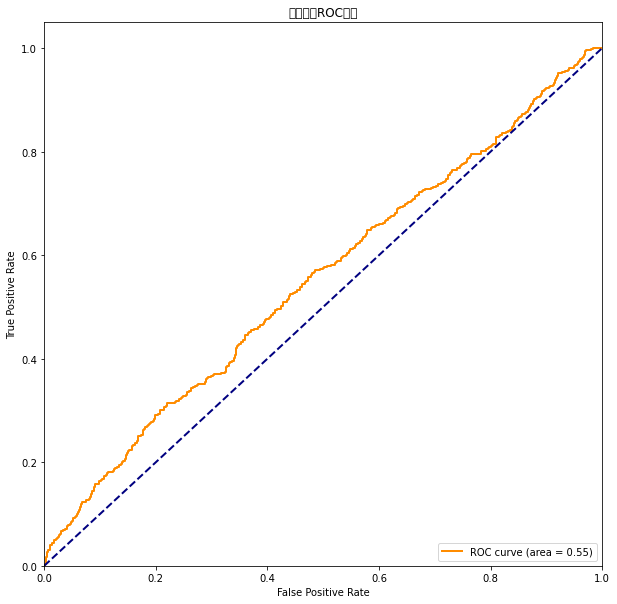

OUTLIERS :  187 INLIERS :  1763 Average KNN
使用算法Local Outlier Factor (LOF) 进行建模：

在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5396, precision @ rank n:0.4078

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5402, precision @ rank n:0.4144


<Figure size 432x288 with 0 Axes>

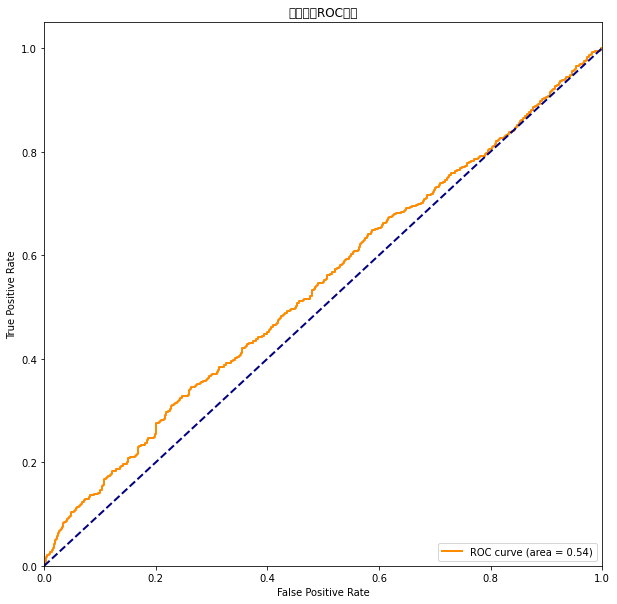

OUTLIERS :  209 INLIERS :  1741 Local Outlier Factor (LOF)
使用算法Connectivity-Based Outlier Factor (COF) 进行建模：

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5396, precision @ rank n:0.4078

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5402, precision @ rank n:0.4144


<Figure size 432x288 with 0 Axes>

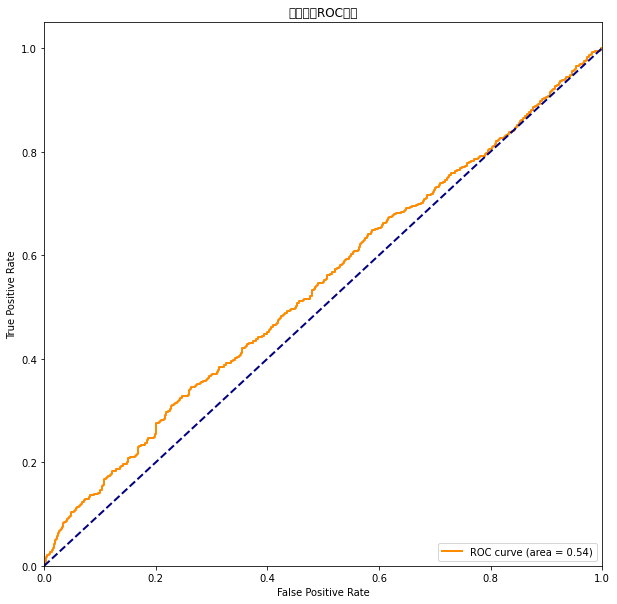

OUTLIERS :  209 INLIERS :  1741 Connectivity-Based Outlier Factor (COF)
使用算法Principal Component Analysis Outlier Detector (PCA) 进行建模：

在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5466, precision @ rank n:0.4114

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5714, precision @ rank n:0.447


<Figure size 432x288 with 0 Axes>

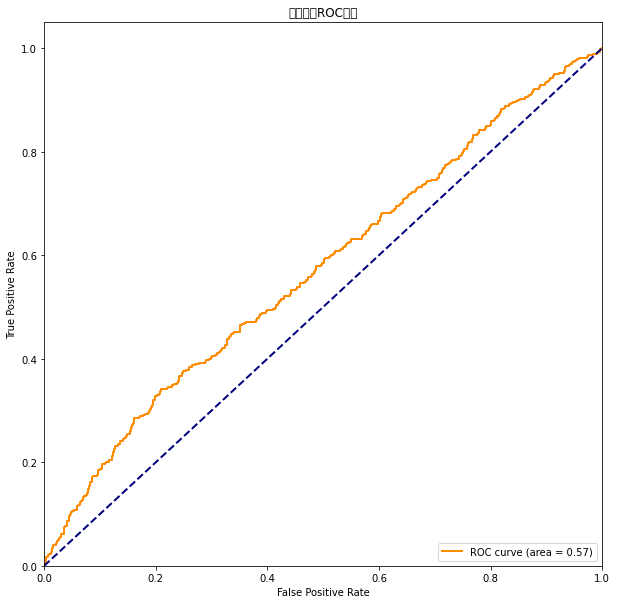

OUTLIERS :  182 INLIERS :  1768 Principal Component Analysis Outlier Detector (PCA)


In [13]:
from pyod.utils.data import evaluate_print 
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from sklearn import model_selection

X = trainDF[[ 'fixed.acidity', 'volatile.acidity', 'citric.acid',
       'residual.sugar', 'chlorides', 'free.sulfur.dioxide',
       'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol']].values
Y = trainDF['ground.truth'].values

#划分测试数据集和训练数据集
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3,random_state=0)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    print("使用算法"+clf_name+" 进行建模：")
    clf.fit(x_train)
  
    # 返回训练数据x_train上的异常标签和异常分值
    y_train_pred = clf.labels_  
    y_train_scores = clf.decision_scores_ 
    
# 用训练好的clf来预测未知数据中的异常值
    # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
    y_test_pred = clf.predict(x_test) 
    
    #  返回未知数据上的异常值 (分值越大越异常)
    y_test_scores = clf.decision_function(x_test) 
    
    y_train_scores = y_train_scores.reshape(-1,1)
    y_test_scores = y_test_scores.reshape(-1,1)
    
    y_train_scores = y_train_scores.reshape(-1, 1)
    y_test_scores = y_test_scores.reshape(-1, 1)
    # if scores contain nan, change it to 0
    if np.isnan(y_train_scores).any():
         y_train_scores = np.nan_to_num(y_train_scores)
    if np.isnan(y_test_scores).any():
         y_test_scores = np.nan_to_num(y_test_scores)
#     train_scores_norm, test_scores_norm = standardizer(y_train_scores, y_test_scores)
    
    print("\n在训练数据集中:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\n在测试数据集中:")
    evaluate_print(clf_name, y_test, y_test_scores)
    
    # 绘制ROC图
    fpr,tpr,threshold = roc_curve(y_test, y_test_scores) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('测试数据ROC曲线')
    plt.legend(loc="lower right")
    plt.show()
    
    # 计算离群点的个数
    n_inliers = len(y_test_pred) - np.count_nonzero(y_test_pred)
    n_outliers = np.count_nonzero(y_test_pred == 1)

#     dfx = wineDF
#     dfx['outlier'] = y_test_pred.tolist()
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        


### 1.5 处理包含noise的数据集

In [14]:
# 构造数据集
trainDF = wineNDF
trainDF['ground.truth']=trainDF['ground.truth'].map({'nominal': 0,'anomaly':1})

### 1.5.1 开始训练，并在测试数据集上进行预测。最后计算ROC以及precision, 并绘制ROC曲线图，输出离群点的个数

使用算法Fast Angle-based Outlier Detector (F_ABOD) 进行建模：

在训练数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.5193, precision @ rank n:0.117

在测试数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.5392, precision @ rank n:0.1543


<Figure size 432x288 with 0 Axes>

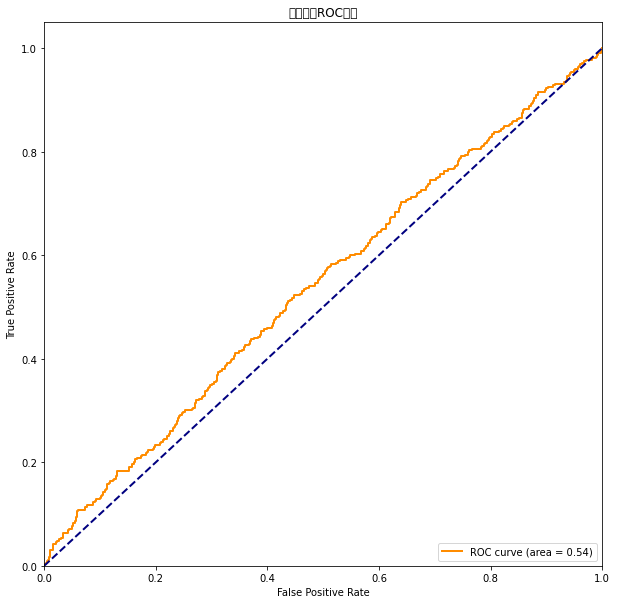

OUTLIERS :  266 INLIERS :  2734 Fast Angle-based Outlier Detector (F_ABOD)
使用算法Cluster-based Local Outlier Factor (CBLOF) 进行建模：

在训练数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.5168, precision @ rank n:0.117

在测试数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.5272, precision @ rank n:0.1343


<Figure size 432x288 with 0 Axes>

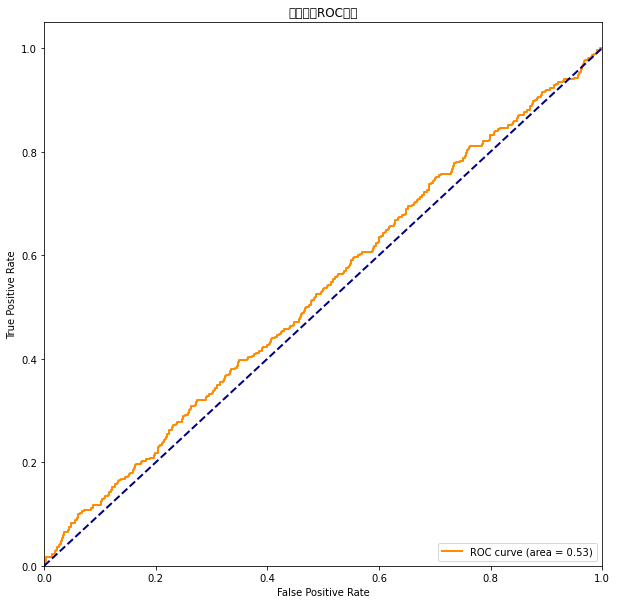

OUTLIERS :  325 INLIERS :  2675 Cluster-based Local Outlier Factor (CBLOF)
使用算法Feature Bagging 进行建模：

在训练数据集中:
Feature Bagging ROC:0.5148, precision @ rank n:0.1196

在测试数据集中:
Feature Bagging ROC:0.5255, precision @ rank n:0.1486


<Figure size 432x288 with 0 Axes>

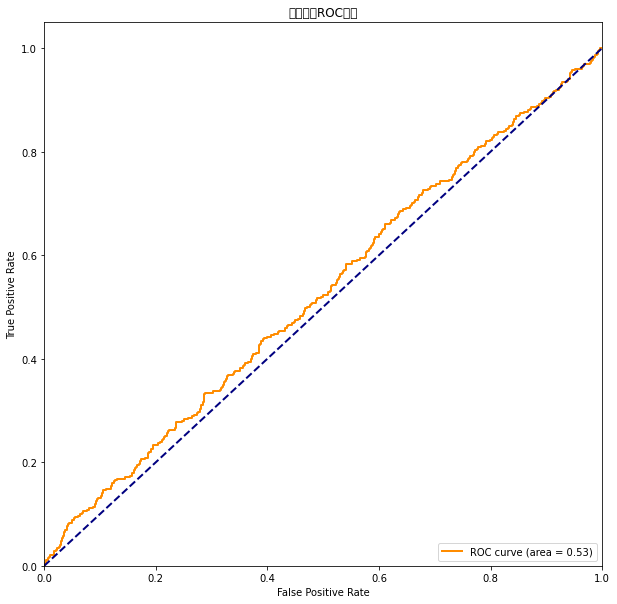

OUTLIERS :  304 INLIERS :  2696 Feature Bagging
使用算法Histogram-base Outlier Detection (HBOS) 进行建模：

在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5369, precision @ rank n:0.1445

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5359, precision @ rank n:0.1486


<Figure size 432x288 with 0 Axes>

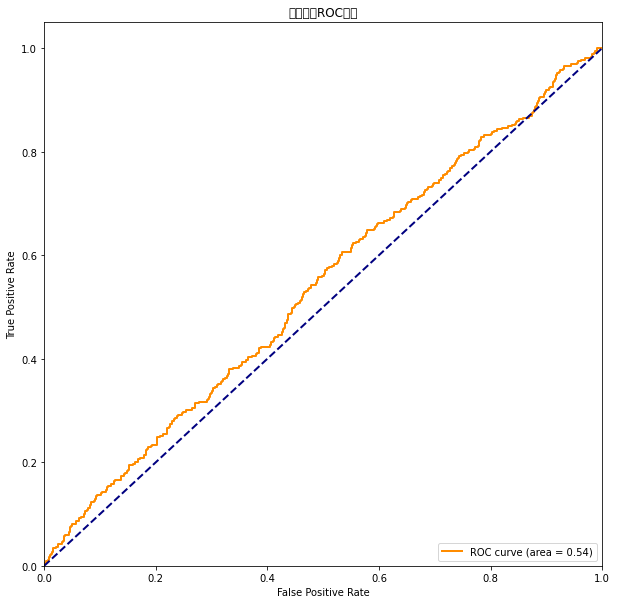

OUTLIERS :  297 INLIERS :  2703 Histogram-base Outlier Detection (HBOS)
使用算法Isolation Forest 进行建模：

在训练数据集中:
Isolation Forest ROC:0.514, precision @ rank n:0.1156

在测试数据集中:
Isolation Forest ROC:0.5214, precision @ rank n:0.1457


<Figure size 432x288 with 0 Axes>

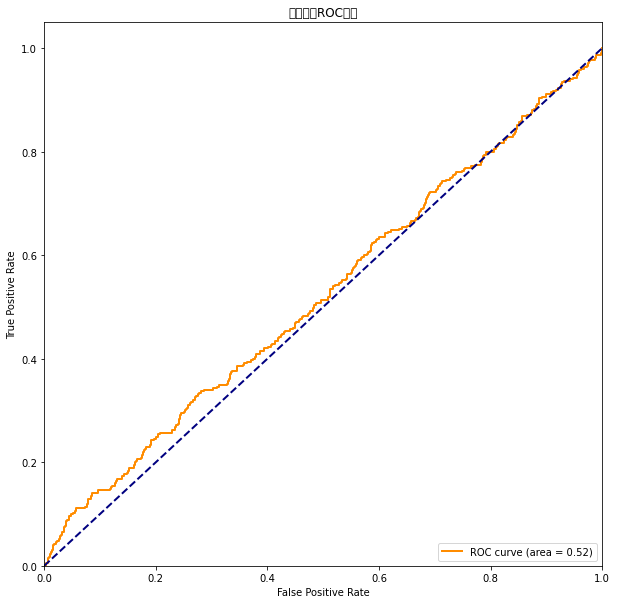

OUTLIERS :  308 INLIERS :  2692 Isolation Forest
使用算法K Nearest Neighbors (KNN) 进行建模：

在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5332, precision @ rank n:0.1235

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5481, precision @ rank n:0.16


<Figure size 432x288 with 0 Axes>

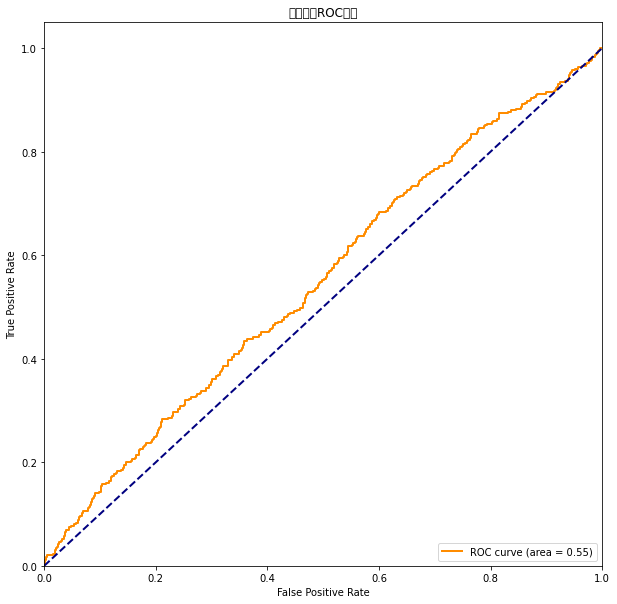

OUTLIERS :  325 INLIERS :  2675 K Nearest Neighbors (KNN)
使用算法Average KNN 进行建模：

在训练数据集中:
Average KNN ROC:0.5268, precision @ rank n:0.1275

在测试数据集中:
Average KNN ROC:0.5491, precision @ rank n:0.1457


<Figure size 432x288 with 0 Axes>

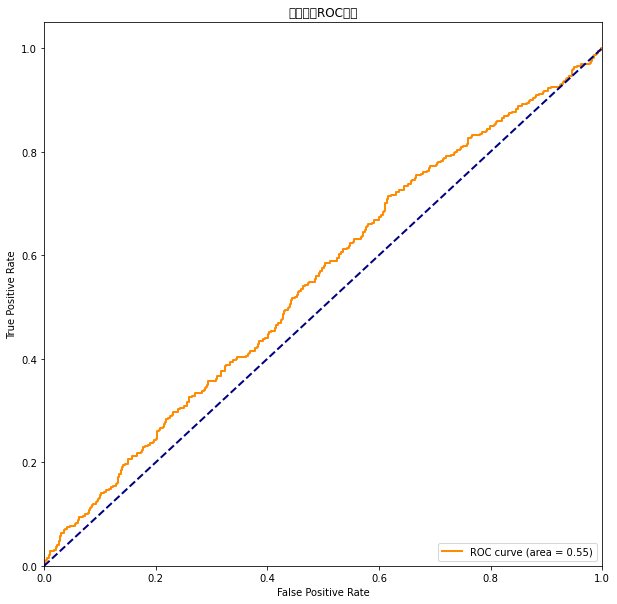

OUTLIERS :  315 INLIERS :  2685 Average KNN
使用算法Local Outlier Factor (LOF) 进行建模：

在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5184, precision @ rank n:0.1248

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5292, precision @ rank n:0.1429


<Figure size 432x288 with 0 Axes>

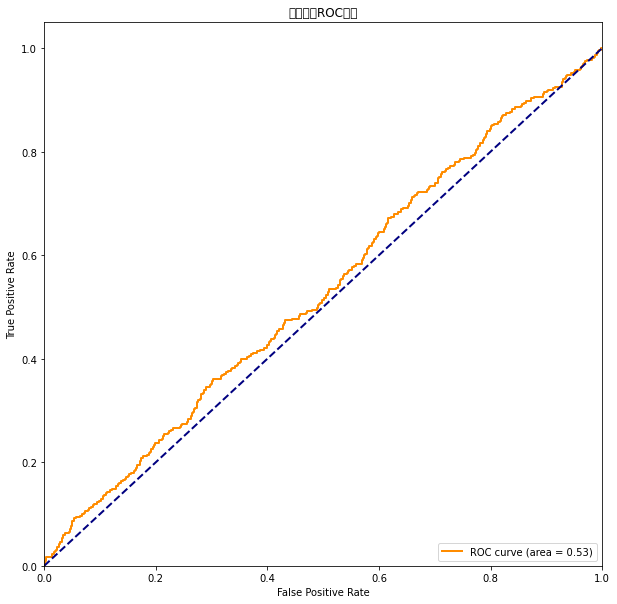

OUTLIERS :  316 INLIERS :  2684 Local Outlier Factor (LOF)
使用算法Connectivity-Based Outlier Factor (COF) 进行建模：

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5184, precision @ rank n:0.1248

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5292, precision @ rank n:0.1429


<Figure size 432x288 with 0 Axes>

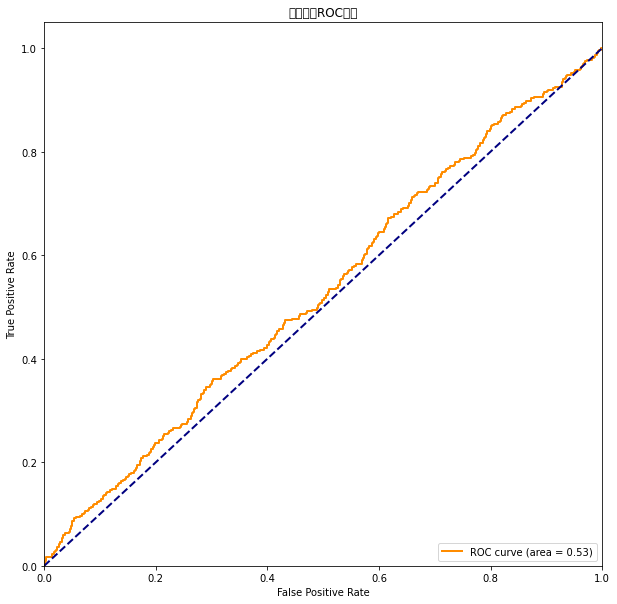

OUTLIERS :  316 INLIERS :  2684 Connectivity-Based Outlier Factor (COF)
使用算法Principal Component Analysis Outlier Detector (PCA) 进行建模：

在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5313, precision @ rank n:0.134

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5429, precision @ rank n:0.1714


<Figure size 432x288 with 0 Axes>

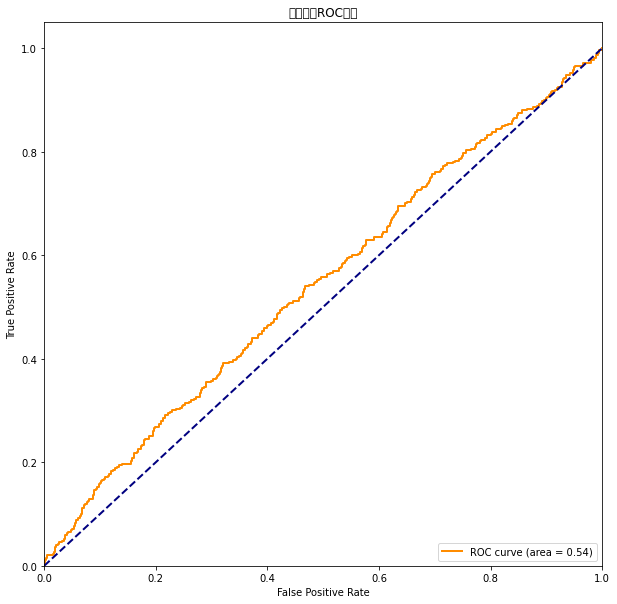

OUTLIERS :  318 INLIERS :  2682 Principal Component Analysis Outlier Detector (PCA)


In [15]:
from pyod.utils.data import evaluate_print 
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from sklearn import model_selection

X = trainDF[[ 'fixed.acidity', 'volatile.acidity', 'citric.acid',
       'residual.sugar', 'chlorides', 'free.sulfur.dioxide',
       'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'noise..1', 'noise..2', 'noise..3', 'noise..4', 'noise..5', 'noise..6',
       'noise..7', 'noise..8', 'noise..9', 'noise..10', 'noise..11',
       'noise..12', 'noise..13', 'noise..14', 'noise..15', 'noise..16',
       'noise..17', 'noise..18', 'noise..19', 'noise..20', 'noise..21',
       'noise..22', 'noise..23', 'noise..24', 'noise..25', 'noise..26',
       'noise..27', 'noise..28', 'noise..29', 'noise..30', 'noise..31',
       'noise..32', 'noise..33']].values
Y = trainDF['ground.truth'].values

#划分测试数据集和训练数据集
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3,random_state=0)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    print("使用算法"+clf_name+" 进行建模：")
    clf.fit(x_train)
  
    # 返回训练数据x_train上的异常标签和异常分值
    y_train_pred = clf.labels_  
    y_train_scores = clf.decision_scores_ 
    
# 用训练好的clf来预测未知数据中的异常值
    # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
    y_test_pred = clf.predict(x_test) 
    
    #  返回未知数据上的异常值 (分值越大越异常)
    y_test_scores = clf.decision_function(x_test) 
    
    y_train_scores = y_train_scores.reshape(-1,1)
    y_test_scores = y_test_scores.reshape(-1,1)
    
    y_train_scores = y_train_scores.reshape(-1, 1)
    y_test_scores = y_test_scores.reshape(-1, 1)
    # if scores contain nan, change it to 0
    if np.isnan(y_train_scores).any():
         y_train_scores = np.nan_to_num(y_train_scores)
    if np.isnan(y_test_scores).any():
         y_test_scores = np.nan_to_num(y_test_scores)
#     train_scores_norm, test_scores_norm = standardizer(y_train_scores, y_test_scores)
    
    print("\n在训练数据集中:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\n在测试数据集中:")
    evaluate_print(clf_name, y_test, y_test_scores)
    
    # 绘制ROC图
    fpr,tpr,threshold = roc_curve(y_test, y_test_scores) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('测试数据ROC曲线')
    plt.legend(loc="lower right")
    plt.show()
    
    # 计算离群点的个数
    n_inliers = len(y_test_pred) - np.count_nonzero(y_test_pred)
    n_outliers = np.count_nonzero(y_test_pred == 1)

#     dfx = wineDF
#     dfx['outlier'] = y_test_pred.tolist()
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        


### 3.总结

### (吐槽）这里是将所有数据集合并并删除重复数据之后进行的分析，其他相同benchmark中的文件，完全可以使用相同的方法进行分析（加个for循环即可），多以没有浪费大家的时间进行处理。
### 我使用了不同种类的11种方法进行建模，其中单样本检测方法有10种，包括线性模型PCA；基于近邻的方法LOF、COF、KNN、Average KNN、CBLOF、HBOS；基于概率统计的方法ABOD（耗时较久）、FastABOD；以及基于离群值集合的方法Isolation Forest ；和1种离群组合框架方法 Feature Bagging。
### 该问题可以看做二分类问题，因此从ROC曲线和AUC面积中可以清楚地看到，结果中算法KNN在不包含niose的数据集中准确率最高，性能最好。而在包含noise的数据集中，所有算法都表现得不好，需要后期的参数调优。

## 二、处理 abalone_benchmarks 数据集

### 2.1读取所有csv文件并合并成一个dataframe

In [28]:
# 读取所有csv文件
from os import walk
df=[]
dfnoise=[]
for f,_ ,i in walk("F:\\Data Mining\\homework4\\abalone_benchmarks\\abalone\\benchmarks"):
    for j in i:
        temp = pd.read_csv(f+'/'+j)
        if temp.shape[1] ==13:
            df.append(temp)
        elif temp.shape[1]==34:
            dfnoise.append(temp)

In [29]:
len(dfnoise)

435

In [30]:
# 合并成一个dataframe
dfAll = pd.concat(df)
dfNAll = pd.concat(dfnoise)
print(dfAll.columns)
print(dfNAll.columns)

Index(['point.id', 'motherset', 'origin', 'original.label', 'diff.score',
       'ground.truth', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7'],
      dtype='object')
Index(['point.id', 'motherset', 'origin', 'original.label', 'diff.score',
       'ground.truth', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'noise..1',
       'noise..2', 'noise..3', 'noise..4', 'noise..5', 'noise..6', 'noise..7',
       'noise..8', 'noise..9', 'noise..10', 'noise..11', 'noise..12',
       'noise..13', 'noise..14', 'noise..15', 'noise..16', 'noise..17',
       'noise..18', 'noise..19', 'noise..20', 'noise..21'],
      dtype='object')


### 2.2 由于motherset、origin只有一个值，所以舍去该属性

In [31]:
print(dfAll['origin'].value_counts())
print(dfAll['motherset'].value_counts())

regression    703701
Name: origin, dtype: int64
abalone    703701
Name: motherset, dtype: int64


In [32]:
# 属性列表
column_names = ['point.id', 'original.label', 'diff.score',
       'ground.truth', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']
noise_column_names = ['point.id', 'original.label', 'diff.score',
       'ground.truth', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'noise..1',
       'noise..2', 'noise..3', 'noise..4', 'noise..5', 'noise..6', 'noise..7',
       'noise..8', 'noise..9', 'noise..10', 'noise..11', 'noise..12',
       'noise..13', 'noise..14', 'noise..15', 'noise..16', 'noise..17',
       'noise..18', 'noise..19', 'noise..20', 'noise..21']

In [33]:
adaDF = dfAll[column_names]
print('删除前元组数：'+str(len(adaDF)))
# 删除所有属性值都相同的元组
adaDF = adaDF.drop_duplicates()
print('删除后元组数：'+str(len(adaDF)))

adaNDF = dfNAll[noise_column_names]
print('noise数据集删除前元组数：'+str(len(adaNDF)))
# 删除所有属性值都相同的元组
adaNDF = adaNDF.drop_duplicates()
print('noise数据集删除后元组数：'+str(len(adaNDF)))

删除前元组数：703701
删除后元组数：4177
noise数据集删除前元组数：709105
noise数据集删除后元组数：709105


In [35]:
#重现建议序号索引
adaDF.reset_index(inplace=True,drop=True)
#进行随机抽样
adaNDF = adaNDF.sample(10000)

### 2.3 创建模型字典

#### 这里使用上面定义过的模型字典

### 2.4 首先处理不包含noise的数据集

### 2.4.1 开始训练，并在测试数据集上进行预测。最后计算ROC以及precision, 并绘制ROC曲线图，输出离群点的个数

In [36]:
# 构造数据集
trainDF = adaDF
trainDF['ground.truth']=trainDF['ground.truth'].map({'nominal': 0,'anomaly':1})

使用模型Fast Angle-based Outlier Detector (F_ABOD) 进行建模：

在训练数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.7543, precision @ rank n:0.684

在测试数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.7743, precision @ rank n:0.7038


<Figure size 432x288 with 0 Axes>

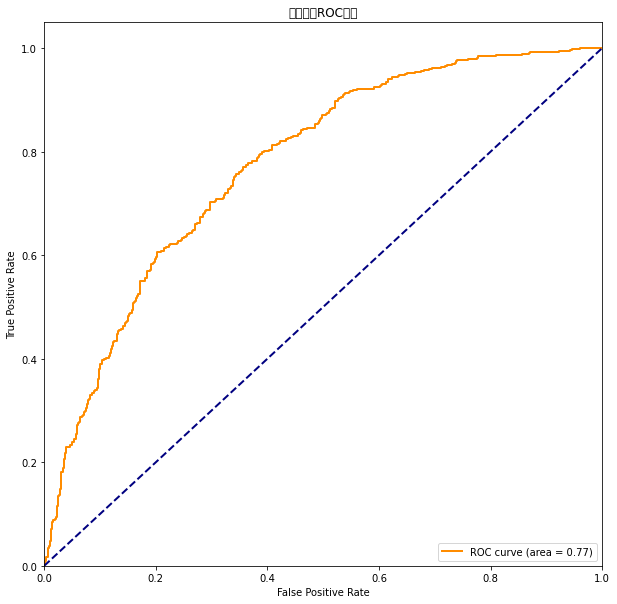

OUTLIERS :  111 INLIERS :  1143 Fast Angle-based Outlier Detector (F_ABOD)
使用模型Cluster-based Local Outlier Factor (CBLOF) 进行建模：

在训练数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.6483, precision @ rank n:0.5946

在测试数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.6659, precision @ rank n:0.616


<Figure size 432x288 with 0 Axes>

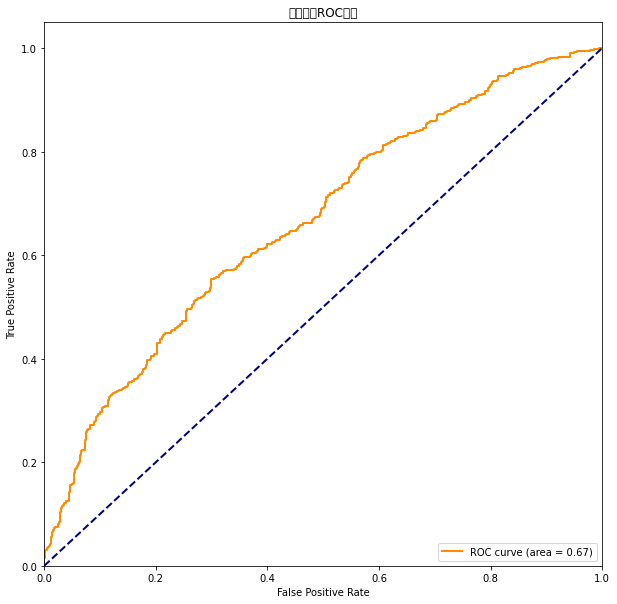

OUTLIERS :  123 INLIERS :  1131 Cluster-based Local Outlier Factor (CBLOF)
使用模型Feature Bagging 进行建模：

在训练数据集中:
Feature Bagging ROC:0.583, precision @ rank n:0.562

在测试数据集中:
Feature Bagging ROC:0.6224, precision @ rank n:0.605


<Figure size 432x288 with 0 Axes>

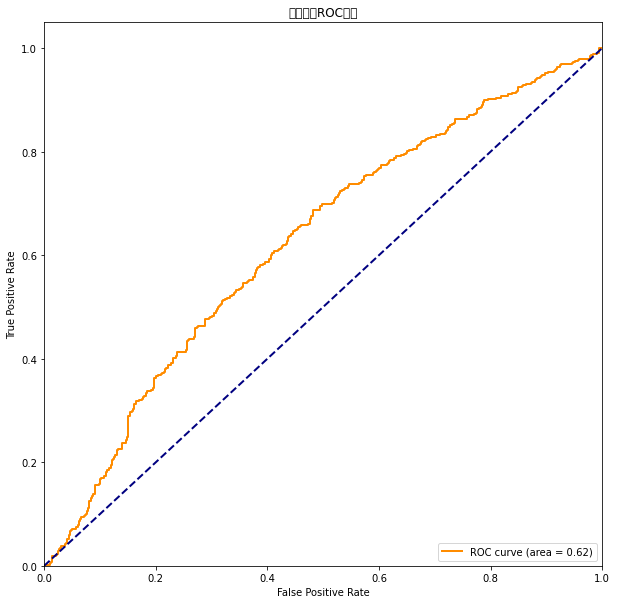

OUTLIERS :  110 INLIERS :  1144 Feature Bagging
使用模型Histogram-base Outlier Detection (HBOS) 进行建模：

在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4587, precision @ rank n:0.4435

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4533, precision @ rank n:0.4545


<Figure size 432x288 with 0 Axes>

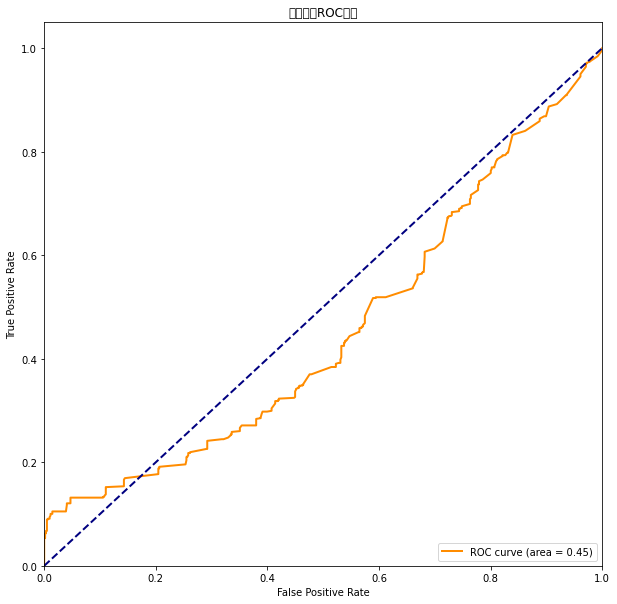

OUTLIERS :  113 INLIERS :  1141 Histogram-base Outlier Detection (HBOS)
使用模型Isolation Forest 进行建模：

在训练数据集中:
Isolation Forest ROC:0.4913, precision @ rank n:0.4726

在测试数据集中:
Isolation Forest ROC:0.4934, precision @ rank n:0.5


<Figure size 432x288 with 0 Axes>

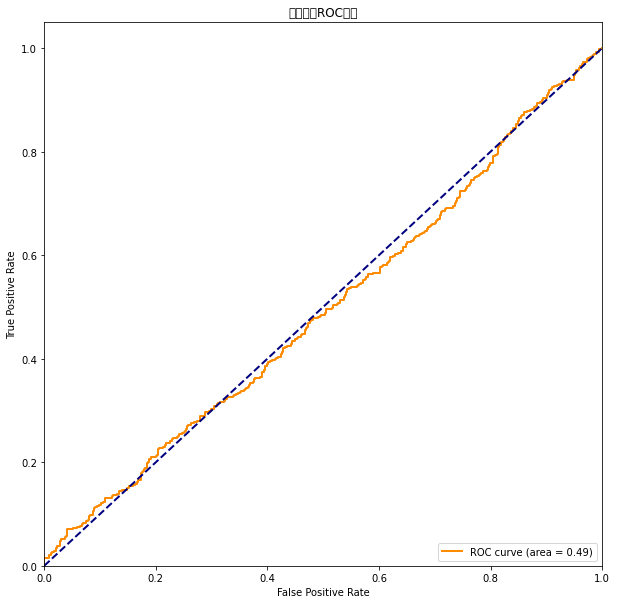

OUTLIERS :  138 INLIERS :  1116 Isolation Forest
使用模型K Nearest Neighbors (KNN) 进行建模：

在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6849, precision @ rank n:0.641

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6907, precision @ rank n:0.6458


<Figure size 432x288 with 0 Axes>

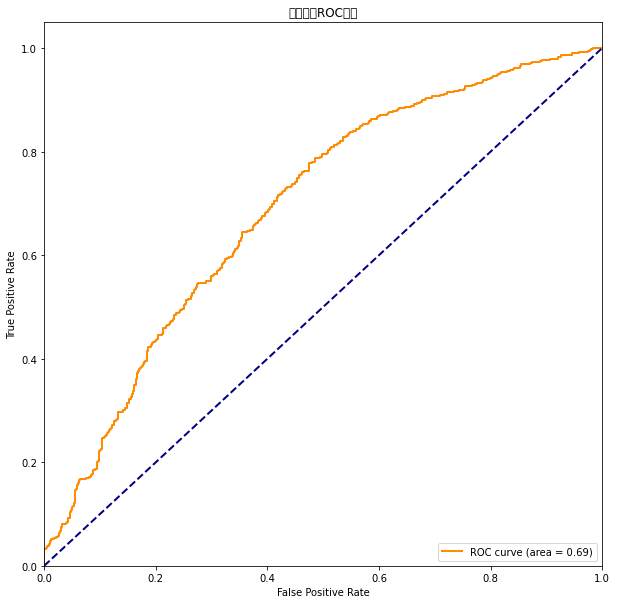

OUTLIERS :  122 INLIERS :  1132 K Nearest Neighbors (KNN)
使用模型Average KNN 进行建模：

在训练数据集中:
Average KNN ROC:0.767, precision @ rank n:0.6875

在测试数据集中:
Average KNN ROC:0.7912, precision @ rank n:0.7257


<Figure size 432x288 with 0 Axes>

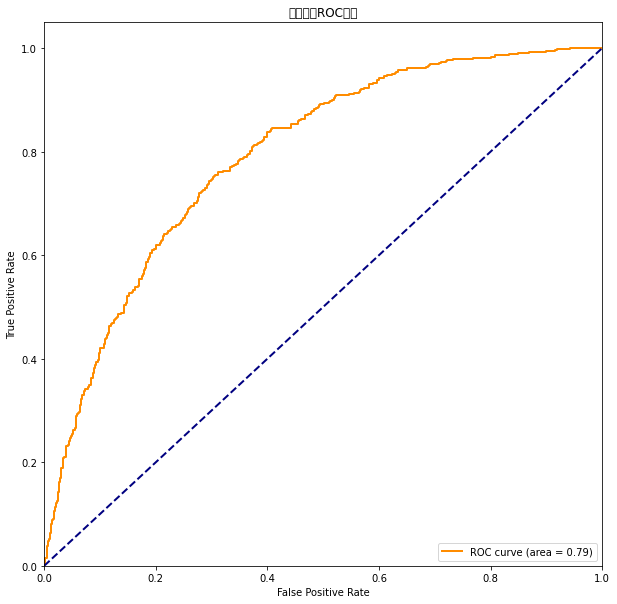

OUTLIERS :  113 INLIERS :  1141 Average KNN
使用模型Local Outlier Factor (LOF) 进行建模：

在训练数据集中:
Local Outlier Factor (LOF) ROC:0.608, precision @ rank n:0.5981

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6222, precision @ rank n:0.6223


<Figure size 432x288 with 0 Axes>

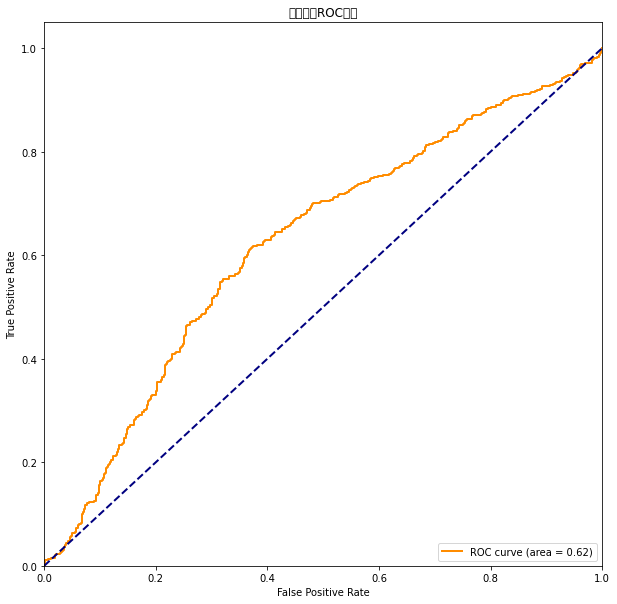

OUTLIERS :  110 INLIERS :  1144 Local Outlier Factor (LOF)
使用模型Connectivity-Based Outlier Factor (COF) 进行建模：

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.608, precision @ rank n:0.5981

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6222, precision @ rank n:0.6223


<Figure size 432x288 with 0 Axes>

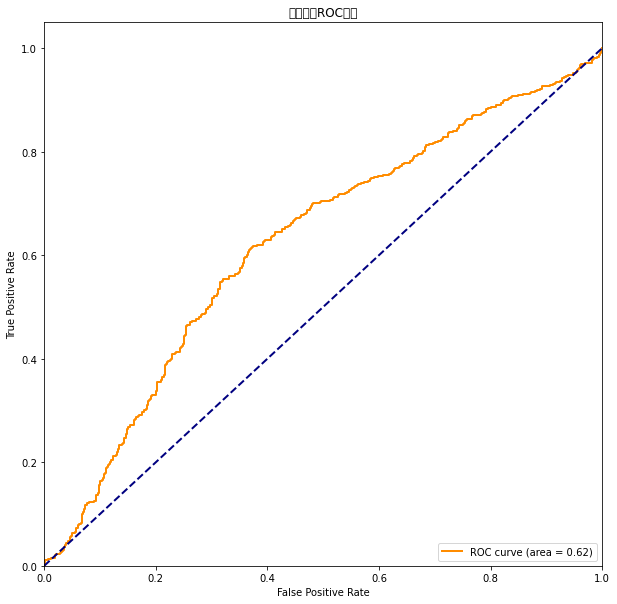

OUTLIERS :  110 INLIERS :  1144 Connectivity-Based Outlier Factor (COF)
使用模型Principal Component Analysis Outlier Detector (PCA) 进行建模：

在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4807, precision @ rank n:0.4782

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.473, precision @ rank n:0.4906


<Figure size 432x288 with 0 Axes>

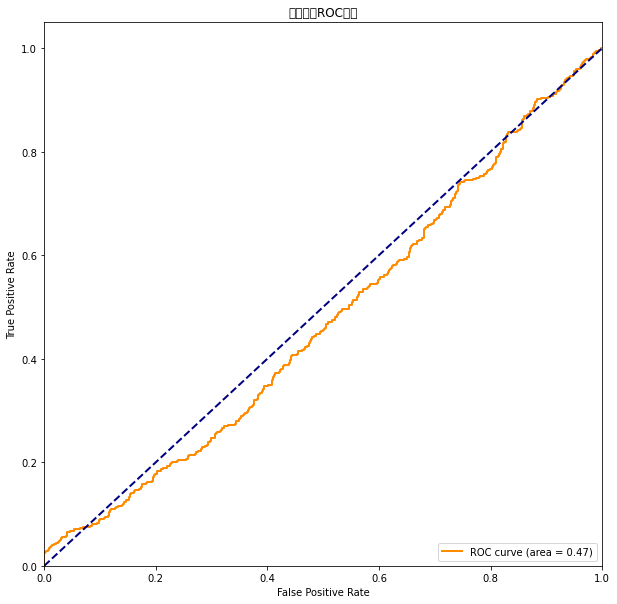

OUTLIERS :  129 INLIERS :  1125 Principal Component Analysis Outlier Detector (PCA)


In [37]:
from pyod.utils.data import evaluate_print 
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from sklearn import model_selection

X = trainDF[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']].values
Y = trainDF['ground.truth'].values

#划分测试数据集和训练数据集
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3,random_state=0)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    print("使用模型"+clf_name+" 进行建模：")
    clf.fit(x_train)
  
    # 返回训练数据x_train上的异常标签和异常分值
    y_train_pred = clf.labels_  
    y_train_scores = clf.decision_scores_ 
    
# 用训练好的clf来预测未知数据中的异常值
    # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
    y_test_pred = clf.predict(x_test) 
    
    #  返回未知数据上的异常值 (分值越大越异常)
    y_test_scores = clf.decision_function(x_test) 
    
    y_train_scores = y_train_scores.reshape(-1,1)
    y_test_scores = y_test_scores.reshape(-1,1)
    
    y_train_scores = y_train_scores.reshape(-1, 1)
    y_test_scores = y_test_scores.reshape(-1, 1)
    # if scores contain nan, change it to 0
    if np.isnan(y_train_scores).any():
         y_train_scores = np.nan_to_num(y_train_scores)
    if np.isnan(y_test_scores).any():
         y_test_scores = np.nan_to_num(y_test_scores)
#     train_scores_norm, test_scores_norm = standardizer(y_train_scores, y_test_scores)
    
    print("\n在训练数据集中:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\n在测试数据集中:")
    evaluate_print(clf_name, y_test, y_test_scores)
    
    # 绘制ROC图
    fpr,tpr,threshold = roc_curve(y_test, y_test_scores) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('测试数据ROC曲线')
    plt.legend(loc="lower right")
    plt.show()
    
    # 计算离群点的个数
    n_inliers = len(y_test_pred) - np.count_nonzero(y_test_pred)
    n_outliers = np.count_nonzero(y_test_pred == 1)

#     dfx = wineDF
#     dfx['outlier'] = y_test_pred.tolist()
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        


### 该问题也可以看做二分类问题，因此从ROC曲线和AUC面积中可以清楚地看到，在该数据集中，Average KNN和Fast ABOD算法表现得很好，AUC面积为0.79和0.77，测试数据集准确率为0.7和0.62,。同时也存在一些模型不适合对该数据集进行处理，因此可以根据该步骤进行A_KNN和F_ABOD的具体参数调优，来准确对数据集建模，得到更好的结果。

### 2.5 处理包含noise的数据集

### 2.5.1 开始训练，并在测试数据集上进行预测。最后计算ROC以及precision, 并绘制ROC曲线图，输出离群点的个数

In [38]:
# 构造数据集
trainDF = adaNDF
trainDF['ground.truth']=trainDF['ground.truth'].map({'nominal': 0,'anomaly':1})

使用模型Fast Angle-based Outlier Detector (F_ABOD) 进行建模：

在训练数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.5494, precision @ rank n:0.1463

在测试数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.5631, precision @ rank n:0.192


<Figure size 432x288 with 0 Axes>

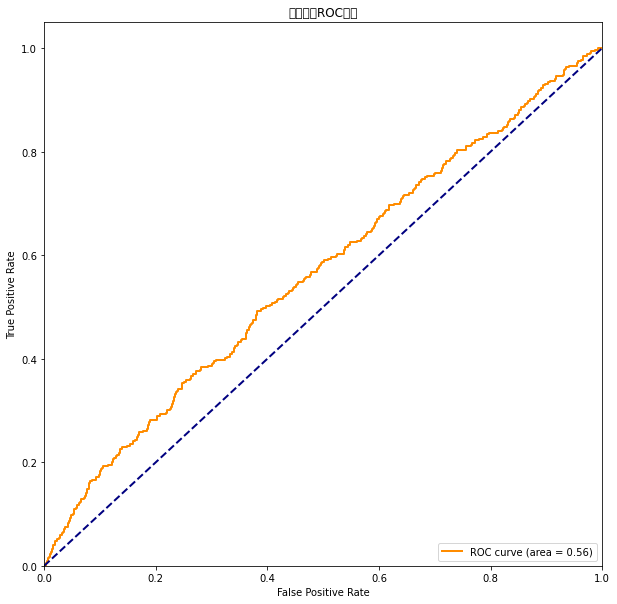

OUTLIERS :  347 INLIERS :  2653 Fast Angle-based Outlier Detector (F_ABOD)
使用模型Cluster-based Local Outlier Factor (CBLOF) 进行建模：

在训练数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.5305, precision @ rank n:0.1535

在测试数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.547, precision @ rank n:0.1719


<Figure size 432x288 with 0 Axes>

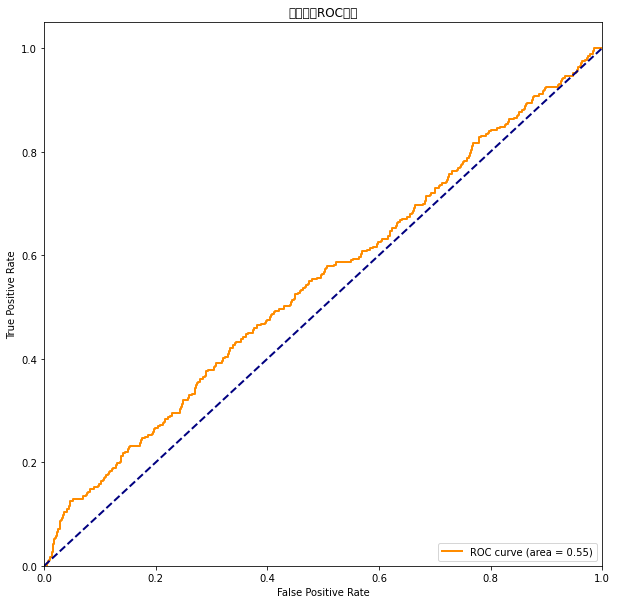

OUTLIERS :  354 INLIERS :  2646 Cluster-based Local Outlier Factor (CBLOF)
使用模型Feature Bagging 进行建模：

在训练数据集中:
Feature Bagging ROC:0.545, precision @ rank n:0.1583

在测试数据集中:
Feature Bagging ROC:0.554, precision @ rank n:0.1862


<Figure size 432x288 with 0 Axes>

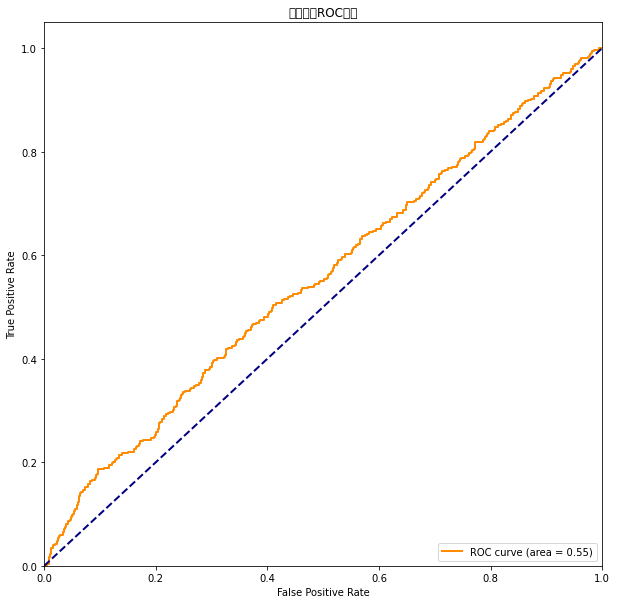

OUTLIERS :  336 INLIERS :  2664 Feature Bagging
使用模型Histogram-base Outlier Detection (HBOS) 进行建模：

在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.6433, precision @ rank n:0.2938

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.6582, precision @ rank n:0.3238


<Figure size 432x288 with 0 Axes>

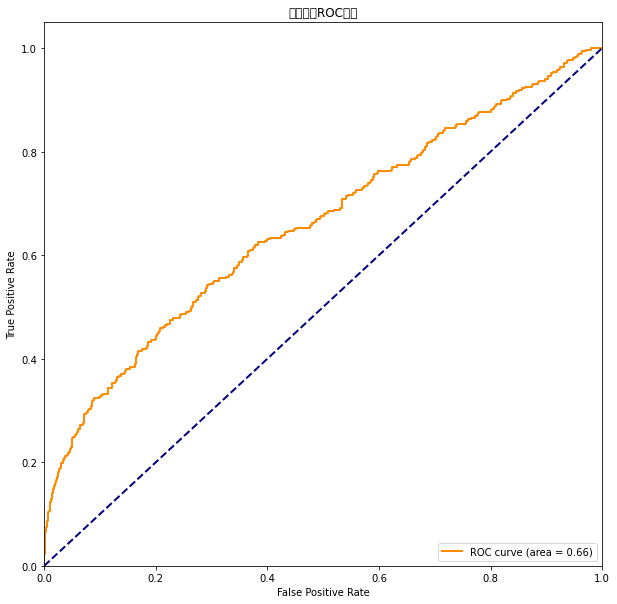

OUTLIERS :  314 INLIERS :  2686 Histogram-base Outlier Detection (HBOS)
使用模型Isolation Forest 进行建模：

在训练数据集中:
Isolation Forest ROC:0.6086, precision @ rank n:0.2518

在测试数据集中:
Isolation Forest ROC:0.6016, precision @ rank n:0.2636


<Figure size 432x288 with 0 Axes>

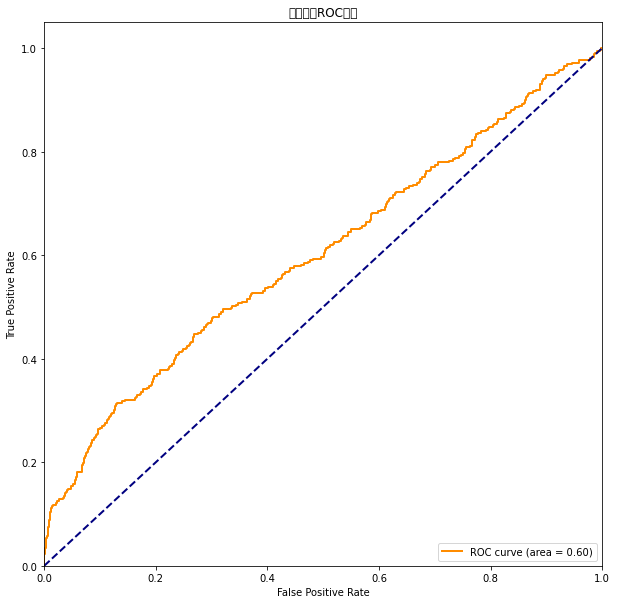

OUTLIERS :  320 INLIERS :  2680 Isolation Forest
使用模型K Nearest Neighbors (KNN) 进行建模：

在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5795, precision @ rank n:0.1799

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5824, precision @ rank n:0.2034


<Figure size 432x288 with 0 Axes>

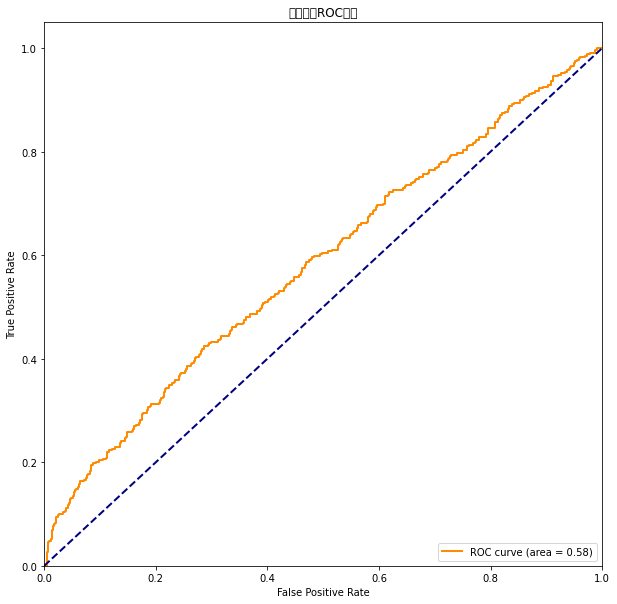

OUTLIERS :  315 INLIERS :  2685 K Nearest Neighbors (KNN)
使用模型Average KNN 进行建模：

在训练数据集中:
Average KNN ROC:0.567, precision @ rank n:0.1739

在测试数据集中:
Average KNN ROC:0.5838, precision @ rank n:0.1977


<Figure size 432x288 with 0 Axes>

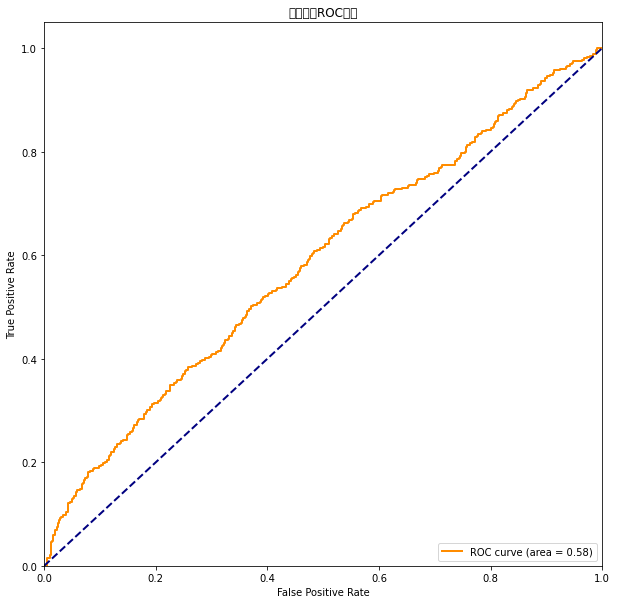

OUTLIERS :  329 INLIERS :  2671 Average KNN
使用模型Local Outlier Factor (LOF) 进行建模：

在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5502, precision @ rank n:0.1523

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5608, precision @ rank n:0.1719


<Figure size 432x288 with 0 Axes>

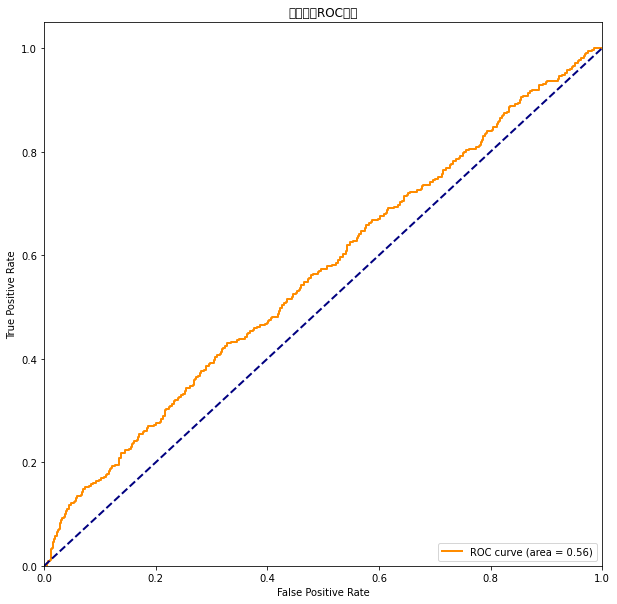

OUTLIERS :  333 INLIERS :  2667 Local Outlier Factor (LOF)
使用模型Connectivity-Based Outlier Factor (COF) 进行建模：

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5502, precision @ rank n:0.1523

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5608, precision @ rank n:0.1719


<Figure size 432x288 with 0 Axes>

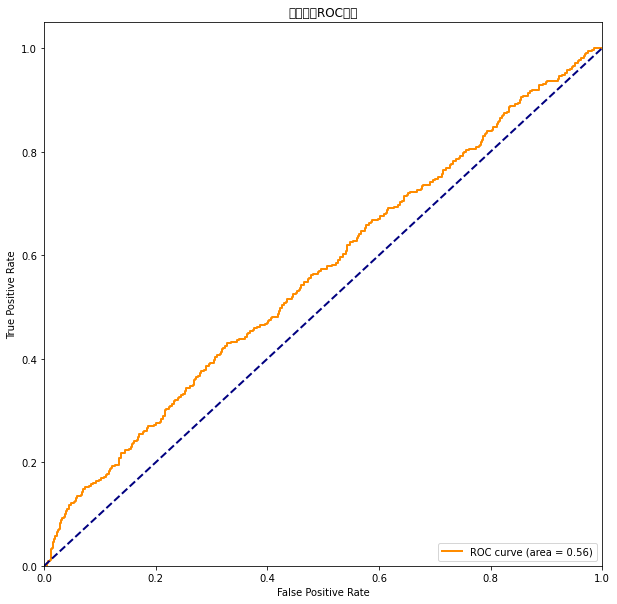

OUTLIERS :  333 INLIERS :  2667 Connectivity-Based Outlier Factor (COF)
使用模型Principal Component Analysis Outlier Detector (PCA) 进行建模：

在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6026, precision @ rank n:0.2254

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5991, precision @ rank n:0.2407


<Figure size 432x288 with 0 Axes>

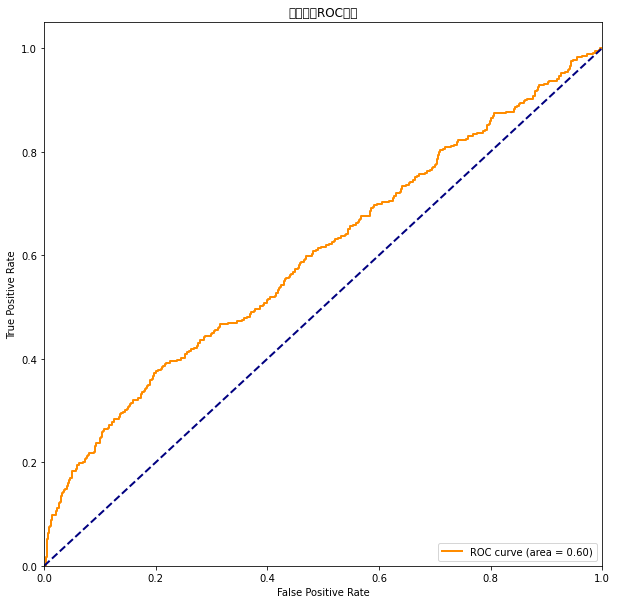

OUTLIERS :  301 INLIERS :  2699 Principal Component Analysis Outlier Detector (PCA)


In [39]:
from pyod.utils.data import evaluate_print 
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from sklearn import model_selection

X = trainDF[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'noise..1',
       'noise..2', 'noise..3', 'noise..4', 'noise..5', 'noise..6', 'noise..7',
       'noise..8', 'noise..9', 'noise..10', 'noise..11', 'noise..12',
       'noise..13', 'noise..14', 'noise..15', 'noise..16', 'noise..17',
       'noise..18', 'noise..19', 'noise..20', 'noise..21']].values
Y = trainDF['ground.truth'].values

#划分测试数据集和训练数据集
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3,random_state=0)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    print("使用模型"+clf_name+" 进行建模：")
    clf.fit(x_train)
  
    # 返回训练数据x_train上的异常标签和异常分值
    y_train_pred = clf.labels_  
    y_train_scores = clf.decision_scores_ 
    
# 用训练好的clf来预测未知数据中的异常值
    # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
    y_test_pred = clf.predict(x_test) 
    
    #  返回未知数据上的异常值 (分值越大越异常)
    y_test_scores = clf.decision_function(x_test) 
    
    y_train_scores = y_train_scores.reshape(-1,1)
    y_test_scores = y_test_scores.reshape(-1,1)
    
    y_train_scores = y_train_scores.reshape(-1, 1)
    y_test_scores = y_test_scores.reshape(-1, 1)
    # if scores contain nan, change it to 0
    if np.isnan(y_train_scores).any():
         y_train_scores = np.nan_to_num(y_train_scores)
    if np.isnan(y_test_scores).any():
         y_test_scores = np.nan_to_num(y_test_scores)
#     train_scores_norm, test_scores_norm = standardizer(y_train_scores, y_test_scores)
    
    print("\n在训练数据集中:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\n在测试数据集中:")
    evaluate_print(clf_name, y_test, y_test_scores)
    
    # 绘制ROC图
    fpr,tpr,threshold = roc_curve(y_test, y_test_scores) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('测试数据ROC曲线')
    plt.legend(loc="lower right")
    plt.show()
    
    # 计算离群点的个数
    n_inliers = len(y_test_pred) - np.count_nonzero(y_test_pred)
    n_outliers = np.count_nonzero(y_test_pred == 1)

#     dfx = wineDF
#     dfx['outlier'] = y_test_pred.tolist()
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        


### 从ROC曲线和AUC面积中可以清楚地看到，在该数据集中，HBOS算法表现得很好，AUC面积为0.66。